<div align="center">

# Computing Equilibria in Repeated Zero-Sum Games
## A Comparative Study of Fictitious Play and Reinforcement Learning

<br>

**Student:** Ioannis Petrousov  
**Email:** [contact@petrousoft.com](mailto:contact@petrousoft.com)  

<br>

**MSc in Artificial Intelligence**  
**Course:** Intelligent Agents and Multiagent Systems  
**Date:** February 2026

<br>
<br>

| | |
|:---:|:---:|
| <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSSFd6A0n_C6Wb_JrgfkI0GioEeeCFArki1-g&s" width="200"/> | <img src="https://upload.wikimedia.org/wikipedia/en/thumb/a/a4/UNIPI_Emblem.png/250px-UNIPI_Emblem.png" width="200"/> |
| **NCSR Demokritos** | **University of Piraeus** |

<br>

---

</div>

<div align="center">
    <h1>Repeated & zero sum (stochastic) games</h1>
</div>

<div align="center">
    <h2>Zero-sum game</h2>
</div>

- competing entities
- the result is an advantage for one side and an equivalent loss for the other (+5, -5)
- the net improvement in benefit of the whole game is zero.
- Why? The advantage for one side is an equal loss for the other side.
- This sum is zero.

**Examples of games**
- Black Jack
- Chess
- Sports?

<div align="center">
    <h2>Repeated/Iterated game</h2>
</div>

- The same stage is played at each timeframe.
- Repeated number of repetitions of a base game (stage game)
- Same game, multiple games
- Stage Game: The single-shot game played in each period.

<div align="center">
    <h2>Stochastic/Markov games</h2>
</div>

- dynamic, multi-agent
- probabilities influence the transition to next state
- player strategies depend only on the current state

<div align="center">
    <h2>The goal</h2>
</div>

Construct a game/environment which combines the above 3 characteristics.
In other words, it asks for a Competitive Markov Game, a two-player zero-sum game.

# Implementations

## 1. Rock-Paper-Scissors - RPS

To test the agents, we implement a simple Rock Paper Scissors - RPS environment. In each iteration, the agents play the same game - repeated.

### States
In its simple version, the same state is repeated in each iteration.

In its stochastic version, the state has a transition probability into the next state. In the next state, the rewards are doubled.

1. `State-i`: Initial state: Standard rewards (+1 win, -1 loss)
2. `State-n`: Next state: Rewards of previous state are doubled each time
3. We cap the states to a number to reduce the amount of memory for the agents

### Stochastic transition (P)
- If there's a draw at any state, there's a P-chance to transition into next state in which rewards double.
- Otherwise, game stays in the same state.

### Zero-Sum rewards (R)
- The sum of the rewards for Player 1 and Player 2 is always 0.
- One player wins, other loses: rewards for one is equal penalty for other.

In [236]:
import random

class RPS_environment():
    """
    Rock Paper Scissors environment - simple.
    """

    def __init__(self, payoff_matrix=None, stochastic=False, transition_prob=0.3, max_states=3):

        # Payoff Matrix: Player 1 rows, Player 2 cols
        # 0: Rock
        # 1: Paper
        # 2: Scissors
        # self.matrix = [
        #         # R  P  S
        #         [0, -1, 1],  # R
        #         [1, 0, -1],  # P
        #         [-1, 1, 0],  # S
        #         ]
        
        self.payoff_matrix = payoff_matrix
        self.stochastic = stochastic
        self.state = 0
        self.P = transition_prob
        self.max_states = max_states
        self.score1 = 0
        self.score2 = 0
        self.reward1 = 0
        self.reward2 = 0
        self.draws = 0

    def step(self, action1, action2):
        """
        Transition function:
        1. receive actions from players
        2. calculate rewards
        3. update state
        4. return information
        """

        reward1 = self.payoff_matrix[action1][action2]*(self.state+1)
        reward2 = -reward1

        self.update_score(reward1, reward2)
        self.update_reward(reward1, reward2)

        # Calculate transition
        if self.stochastic:
            if action1 == action2:
                if random.random() < self.P:
                    if self.state < self.max_states:
                        # We transition
                        self.state += 1
            else:
                self.reset()

        return self.state, reward1, reward2

    def update_score(self, reward1, reward2):
        """Keep scores of the agents."""
        if reward1>reward2:
            self.score1+=1
        elif reward2>reward1:
            self.score2+=1
        else:
            self.draws+=1

    def update_reward(self, reward1, reward2):
        """Reward counter for each agent."""
        self.reward1 += reward1
        self.reward2 += reward2

    def reset(self):
        """Winning condition reached."""
        self.state = 0

---

<div align="center">
    <h1>Equilibria</h1>
</div>

<div align="center">
    <h2>Nash equilibrium</h2>
</div>

- no player could gain more by changing their play strategy in a game.
- players choose their optimal strategy against the other players constant strategy
- does not guarantee overall best pay-off
- suboptimal for the group
- **Pareto inefficient**

<div align="center">
    <h2>Pareto optimality/efficiency</h2>
</div>

- is a group/collective strategy
- every player is better off
- no players in worse situations (aka no punished players)

---

<div align="center">
    <h1>Agents</h1>
</div>

<div align="center">
    <h2>Fictitious Play - FP agent</h2>
</div>

### Theoretical Foundation

The agent maintains a count of the opponent's historical actions to estimate their mixed strategy. The empirical frequency $\sigma$ for each opponent action $o \in O$ is calculated as:

$$\sigma_{opp}(o) = \frac{C(o)}{\sum_{j \in O} C(j)}$$

Where:
* **$C(o)$**: The total number of times the opponent has played action $o$.
* **$\sigma_{opp}(o)$**: The predicted probability that the opponent will play action $o$ in the current round.

The agent then selects the **Best Response** $a^*$ by maximizing the expected utility:
$$a^* = \arg\max_{a \in A} \sum_{o \in O} \sigma_{opp}(o) \cdot U(a, o)$$

### Implemenentation

In [240]:
class FictitiousPlayAgent():
    """
    Fictitious Play Agent: A model based agent.
    """

    def __init__(self, payoff_matrix):
        # Times a move has been played
                      #R #P #S
        self.counts = [1, 1, 1]

        # Probability distribution
                      #R #P #S
        self.sigma = [0, 0, 0]

        # Utility matrix
        self.rows = 3
        self.cols = 3
        self.payoff_matrix = payoff_matrix

    def action(self, opponent_action):
        """
        Calculate the best action and ACT.
        """
        if opponent_action is not None:
            self.update_counts(opponent_action)
            self.update_sigma(opponent_action)
            best_move = self.find_best_move()
        else:
            best_move = random.randint(0, 2)
        return best_move

    def update_counts(self, opponent_action):
        self.counts[opponent_action] += 1

    def update_sigma(self, opponent_action):
        for i in range(len(self.sigma)):
            self.sigma[i] = round(self.counts[i]/sum(self.counts), 3)

    def find_best_move(self):
        """
        Calculates utilities using distribution sigma and returns best move.
        """
        max_u = -float("inf")
        best_move = random.randint(0, 2)
        for i in range(self.rows):
            row_i_sum = sum([a*b for a, b in zip(self.payoff_matrix[i], self.sigma)])
            if row_i_sum > max_u:
                max_u = row_i_sum
                best_move = i

        return best_move

<div align="center">
    <h2>Q-learning</h2>
</div>

### Theoretical Foundation

This implementation represents the baseline version of the Q-Learning algorithm. The agent maintains a "Q-table" to store expected utilities for each available action in a given state. It selects the next action based on the Bellman Equation, which estimates the cumulative future reward.

### Theoretical Limitations in Adversarial Play

While highly effective in stationary environments, this simple RL approach faces significant challenges in zero-sum games like Rock-Paper-Scissors:

**Absence of Opponent Modeling**: The agent does not explicitly account for the opponent's strategy; instead, it treats the adversary as part of the stochastic environment.

**The "Exploitation Trap"**: An agent can become "trapped" in a loop of sub-optimal moves. If a specific action repeatedly yields negative rewards, its value in the Q-table may drop significantly below other actions.

**Convergence Issues**: If the reward received after a successful play is insufficient to lift a negative Q-value back into a competitive range, the agent may indefinitely avoid that action—even if it is the theoretically correct response.

**Predictability**: The agent tends to converge on the single move with the highest current value in its Q-table, making it highly predictable and easily exploitable by a rational opponent.

### Implementation

In [241]:
import numpy as np

class QLearning():
    """Generic Q-Learning algorightm."""

    def __init__(self, states=[0], actions=[0, 1, 2], epsilon_init=0.1):
        # Initialize Q-table
        self.q_table = {state: [0.0 for action in actions] for state in states}
        self.epsilon = epsilon_init
        self.alpha = 0.1
        self.gamma = 0.9
        self.action_space = actions

    def action(self, state):
        """
        Choose an action using the epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            # Explore
            chosen_action = np.random.choice(self.action_space)
        else:
            # Exploit
            state_values = self.q_table[state]
            max_val = max(state_values)
            # If we have multiple max values, choose one randomnly
            best_action = [i for i, v in enumerate(state_values) if v == max_val]
            chosen_action = np.random.choice(best_action)

        return chosen_action
        
    def update_q_value(self, state, action, reward, next_state):
        """
        Update the Q-value using Bellman eq..
        """
        max_next_q = max(self.q_table[next_state])
        # TEmpoeral difference
        td_target = reward + self.gamma * max_next_q

        # New Q value
        self.q_table[state][action] += self.alpha * (td_target - self.q_table[state][action])

<div align="center">
    <h2>Epsilon decay functions</h2>
</div>

To prevent the Q-learning agent from getting stuck in playing the same move - one with highest values Q-table - we introduce the `epsilon_threshold` variable. This variable determines the eploration vs exploitation boundary. Here we implement several epsilon decay function to be used in RL algorithms which utilize Bellman's equation.

### Linear epsilon decay

In this scenario, `epsilon` decays by a stable step which is subtracted in each iteration. This allows for a smooth exploration decay.

Text(0.5, 1.0, 'Linear Epsilon Decay')

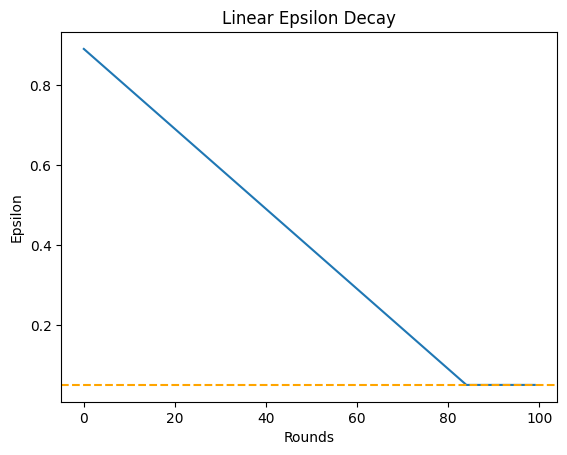

In [246]:
# Linear e
import numpy as np
import matplotlib.pyplot as plt


epsilon = 0.9
step = 0.01
data = []
rounds = 100
epsilon_threshold = 0.05 # Exploration limit

for i in range(rounds):
    if epsilon > epsilon_threshold:
        epsilon -= step
        data.append(round(epsilon, 3))
    else:
        data.append(data[-1])

plt.plot(range(100), data)
plt.xlabel("Rounds")
plt.ylabel("Epsilon")
plt.axhline(y=epsilon_threshold, color="orange", linestyle="--")
plt.title("Linear Epsilon Decay")

### Exponential epsilon decay

In this scenario, epsilon starts from a high value allowing the agent to explore, but then drops real quick transitioning in the exploitation phase. It's considered a good practise to not let exploration decay completely by setting a lower limit for the `epsilon` value.

Text(0.5, 1.0, 'Exponential Epsilon Decay')

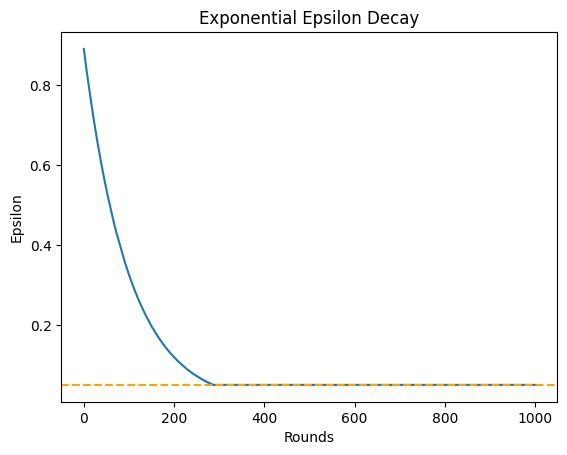

In [428]:
epsilon = 0.9
decay_factor = 0.99
data = []
rounds = 1000
epsilon_threshold = 0.05

for i in range(rounds):
    if epsilon > epsilon_threshold:
        epsilon *= decay_factor
        data.append(round(epsilon, 3))
    else:
        data.append(data[-1])

plt.plot(range(rounds), data)
plt.xlabel("Rounds")
plt.ylabel("Epsilon")
plt.axhline(y=epsilon_threshold, color="orange", linestyle="--")
plt.title("Exponential Epsilon Decay")

<div align="center">
    <h2>Q-learning agent - decaying epsilon</h2>
</div>

### Overview

This implementation improves upon the baseline Q-Learning agent by introducing a dynamic exploration schedule. Rather than maintaining a static probability of random actions, the agent transitions from a heavy exploration phase to a targeted exploitation phase as it gathers more data about the environment.

Key Mechanisms

**Exponential Epsilon Decay**: The exploration rate (ϵ) is multiplied by a decay factor (e.g., 0.99) at each iteration, gradually reducing the frequency of random moves as the agent’s confidence in its Q-table grows.

**Exploration Threshold**: To prevent the agent from becoming completely deterministic or "stuck" in a sub-optimal policy, a minimum exploration floor is maintained. This ensures the agent remains capable of detecting shifts in the opponent's strategy—a critical feature in non-stationary multi-agent games.

**Mitigating Q-Table Stagnation**: By forcing occasional random moves even in late-stage learning, the agent prevents "value collapse," where negative rewards could otherwise cause certain actions to be ignored indefinitely.

### Implementation

In [242]:
import numpy as np

class QLearning_decaying_epsilon():
    """
    Generic Q-Learning algorightm.
    INPUTS:
      states<list> - numbered env states starting from 0
      actions<list>- agent actions list starting from 0
      epsilon_init<float> - initial epsilon value
      epsilon_decay<float> - decay factor for epsilon value
      epsilon_decay_strategy<string> - how epsilon factor should decay: ["exp","lin]
      epsilon_threshold<float> - when should epsilon stop
    """

    def __init__(self, states=[0], actions=[0, 1, 2], epsilon_init=0.9, epsilon_decay=0.949, epsilon_decay_strategy="exp", epsilon_threshold=0.05):
        # Initialize Q-table
        self.q_table = {state: [0.0 for action in actions] for state in states}
        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_strategy = epsilon_decay_strategy
        self.epsilon_threshold = epsilon_threshold
        self.epsilon_history = []
        self.alpha = 0.1
        self.gamma = 0.9
        self.action_space = actions

    def action(self, state):
        """
        Choose an action using the epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            # Explore
            chosen_action = np.random.choice(self.action_space)
        else:
            # Exploit
            state_values = self.q_table[state]
            max_val = max(state_values)
            # If we have multiple max values, choose one randomly
            best_action = [i for i, v in enumerate(state_values) if v == max_val]
            chosen_action = np.random.choice(best_action)

        self.decay_epsilon()

        return chosen_action

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_threshold:
            if self.epsilon_decay_strategy == "exp":
                self.epsilon *= self.epsilon_decay
            elif self.epsilon_decay_strategy == "lin":
                self.epsilon -= self.epsilon_decay
        self.epsilon_history.append(self.epsilon)
        
    def update_q_value(self, state, action, reward, next_state):
        """
        Update the Q-value using Bellman eq..
        """
        max_next_q = max(self.q_table[next_state])
        # TEmpoeral difference
        td_target = reward + self.gamma * max_next_q

        # New Q value
        self.q_table[state][action] += self.alpha * (td_target - self.q_table[state][action])

## Nash Q-Learning

### Theoretical Overview

Minimax Q-Learning (often referred to as Nash Q-Learning in zero-sum contexts) is an extension of standard Q-Learning designed for adversarial multi-agent environments. Unlike standard agents that treat the opponent as static environmental noise, this algorithm assumes a rational adversary who is actively trying to minimize the agent's payoff.

To counter this, the agent seeks to find a Mixed Strategy Nash Equilibrium. Instead of picking a single "best" action, the agent maintains a probability distribution, π, over all available actions (e.g., 1/3 Rock, 1/3 Paper, 1/3 Scissors) to remain unexploitable.

### The Algorithm Logic

Standard Q-Learning tracks Q(s,a). Minimax Q-Learning expands this to: Q(s,a,o), where `o` represents the opponent's action. This allows the agent to model the interaction between its own choices and the opponent's counter-moves for every state.

### The Update Rule

$$Q(s, a, o) \leftarrow (1 - \alpha)Q(s, a, o) + \alpha \left[ r + \gamma V(s') \right]$$

Where:
* **$Q(s, a, o)$**: Expected utility of joint action $(a, o)$ in state $s$.
* **$\alpha$**: Learning rate.
* **$r$**: Immediate reward received.
* **$\gamma$**: Discount factor for future rewards.
* **$V(s')$**: The value of the next state is derived from the Linear Programming solution.

### **Algorithm**

1. **Initialize**: Q table for all combinations of states*actions*op_actions
2. **Action**: Pick an action from the action space based on pi distribution
3. **Observe**: What the opponent chose and what reward you got
4. **Update Q-Table**: Update the specific Q(s,a,o) entry using the reward and the value of the next state.
5. **Solve for π**: Solve the Linear Program (Minimax) using the updated Q-values to find your new optimal π distribution.

### Linear Programming (LP) Solver Logic
To compute the value $V(s)$ and the optimal policy $\pi(s)$, we solve the following optimization problem:

**Maximize $V$** subject to:
1.  **Expected Utility Constraint**:  
    $$\sum_{a \in A} \pi(s, a) Q(s, a, o) \geq V, \quad \forall o \in O$$
2.  **Probability Constraint**:  
    $$\sum_{a \in A} \pi(s, a) = 1$$
3.  **Non-negativity**:  
    $$\pi(s, a) \geq 0, \quad \forall a \in A$$

In our implementation, `scipy.optimize.linprog()` finds the vector $\pi$ that maximizes the minimum possible reward against any opponent move $o$.

#### Solving on paper

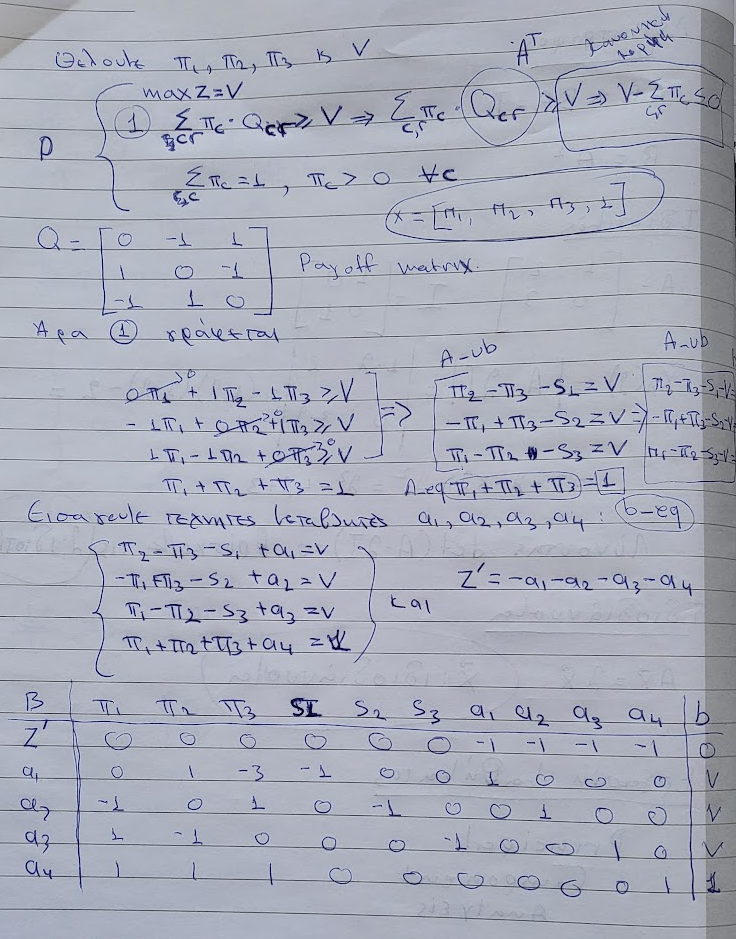

### Implementation

In [207]:
# Minimax Q-learning

class Minimax_QLearning():
    """
    Minimax Q-Learning.
    INPUTS:
      states<list> - numbered env states starting from 0
      actions<list>- agent actions list starting from 0
      epsilon_init<float> - initial epsilon value
      epsilon_decay<float> - decay factor for epsilon value
      epsilon_decay_strategy<string> - how epsilon factor should decay: ["exp","lin]
      epsilon_threshold<float> - when should epsilon stop
      alpha<float> - learning rate
      gamma<float> - discount factor
    """

    def __init__(
            self,
            states=[0],
            actions=[0, 1, 2],
            epsilon_init=0.9,
            epsilon_decay=0.949,
            epsilon_decay_strategy="exp",
            epsilon_threshold=0.05,
            alpha=0.1,
            gamma=0.9):
        """
        Init the minimax Q-Learning agent.
        """
        # Q-table: state -> 2D matrix (our_actions x opp_actions)
        self.q_table = {state: np.zeros((len(actions), len(actions))) for state in states}
        
        # Policy table: state -> probability distribution over actions
        self.pi = {state: [1.0/len(actions) for _ in actions] for state in states}
        
        # State Value table: V(s)
        self.V = {state: 0.0 for state in states}
        
        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_strategy = epsilon_decay_strategy
        self.epsilon_threshold = epsilon_threshold
        self.epsilon_history = []
        self.alpha = alpha
        self.gamma = gamma
        self.action_space = actions
        

    def action(self, state):
        """
        Choose an action using the epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
            # Explore
            chosen_action = np.random.choice(self.action_space)
        else:
            # Exploit - based on pi distribution
            chosen_action = np.random.choice(self.action_space, p=self.pi[state])

        self.decay_epsilon()
        return chosen_action

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_threshold:
            if self.epsilon_decay_strategy == "exp":
                self.epsilon *= self.epsilon_decay
            elif self.epsilon_decay_strategy == "lin":
                self.epsilon -= self.epsilon_decay
        self.epsilon_history.append(self.epsilon)

    def observe(self, state, action, opp_action):
        """
        Observe env.
        opp_action - opponent's action
        """
        pass

    def update_q_value(self, state, action, opp_action, reward, next_state):
            """
            Update Q(s, a, o) and solve the Linear Program for the new policy pi(s).
            """
            # 1. Update the specific Q-cell for the joint action
            # Q(s, a, o) = (1-alpha) * Q(s, a, o) + alpha * (reward + gamma * V(s'))
            # equivalent to Qnew=Qold+α*(Target−Qold)
            target = reward + self.gamma * self.V[next_state]
            self.q_table[state][action][opp_action] += self.alpha * (target - self.q_table[state][action][opp_action])
    
            # 2. Solve Linear Program to find the new V(s) and pi(s)
            self.V[state], self.pi[state] = self._solve_minimax(state)

    def _solve_minimax(self, state):
        """
        Uses Scipy to find the Nash Equilibrium of the current Q-matrix at this state.
        """
        Q = self.q_table[state]
        num_actions = len(self.action_space)

        # Objective function definition:
        # linprog minimizes c^T * x. We want to maximize V, so we minimize -V.
        # x vector: [p1, p2, p3, V]
        # Essentially we pass: c = min(-V)
        c = [0] * num_actions + [-1] # c = [0, 0, 0, -1] = coefficients of [piR, piP, piS, -V]
        
        # Build Inequality Constraints:
        # sum(pi * Q_col) >= V  :=>  V - sum(pi * Q_col) <= 0
        # We go down the row.
        A_ub = []
        for col in range(num_actions):
            constraint = [-Q[row][col] for row in range(num_actions)] + [1]
            A_ub.append(constraint)

        # RHS here is zeros since we move V to the left, above
        b_ub = [0] * num_actions
        
        # Build Equality Constraint:
        # sum(pi) = 1 :=> pi1 + pi2 + pi3 + 0V = 1
        A_eq = [[1] * num_actions + [0]]
        # RHS of equality constraint is 1
        b_eq = [1]

        # Bounds: pi in [0, 1], V is unrestricted (None)
        bounds = [(0, 1)] * num_actions + [(None, None)]

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        if res.success:
            new_pi = res.x[:num_actions] # new pi distribution values
            # To ensure no precision errors lead to negative probabilities, we convert small numbers to zeroes
            new_pi = np.maximum(new_pi, 0)
            # Calculate new pi distribution values
            new_pi /= np.sum(new_pi)
            # Objective value
            new_V = res.x[-1]
            return new_V, new_pi
        else:
            return self.V[state], self.pi[state] # Fallback to old values

---

# Metrics

## Regret
To prove the performance of the agent, we track its regret in each round. In the RPS scenario, the regret for each agent is the opposite of its cummulative reward from each round:

```python
cum_reward1 += reward1
cum_reward2 += reward2
regret_history1.append(-cum_reward1)
regret_history2.append(cum_reward2)
```

### Interpretation

#### Linear Growth
This is the worst case scenario, the agent kept loosing each round and its increased at a steady angle. The agent is making the same mistakes in each round and fails to learn the opponent's moves.

#### Flattened
Perhaps, the line goes up early, as the agent explores, but then flattens out. This means the agent has learned an optimal strategy, against its opponent, and is not exploiting it. It is no longer accumulating regret.

#### Negative slope
If regret goes down, the agent is actively exploiting its opponent's weakness. In each round the agent plays the optinal strategy against its opponent, thus we have Nash equilibrium.

In [179]:
# Plot regret

import matplotlib.pyplot as plt

def plot_regret(rounds, regret_history1, agent_type1, regret_history2, agent_type2):
    plt.plot(range(rounds), regret_history1, label=agent_type1, linestyle="-")
    plt.plot(range(rounds), regret_history2, label=agent_type2, linestyle="--")
    plt.xlabel("Rounds")
    plt.ylabel("Regret")
    plt.legend()
    plt.title("Regret histories")

## Epsilon
This variable determines the exploration vs exploitation threshold. It's useful to track it against Regret in order to attempt to find a correlation between the two values.

In [213]:
import matplotlib.pyplot as plt

def plot_epsilon_regret(
        rounds, 
        regret_history1, 
        agent_type1, 
        regret_history2, 
        agent_type2, 
        epsilon_history1=None, 
        epsilon_history2=None):
    """
    Plot Regret on the left Y-axis and Epsilon on the right Y-axis.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # --- Primary Y-Axis: Regret ---
    ax1.set_xlabel("Rounds")
    ax1.set_ylabel("Cumulative Regret", color="black")
    
    line1, = ax1.plot(
        range(rounds), regret_history1, label=f"{agent_type1} Regret", 
        linestyle="-", color="tab:blue"
    )
    line2, = ax1.plot(
        range(rounds), regret_history2, label=f"{agent_type2} Regret", 
        linestyle="--", color="tab:orange"
    )
    
    ax1.axhline(0, color="black", linewidth=0.8, alpha=0.5)
    ax1.grid(True, alpha=0.3)

    # --- Secondary Y-Axis: Epsilon ---
    if epsilon_history1 is not None or epsilon_history2 is not None:
        ax2 = ax1.twinx()
        ax2.set_ylabel("Epsilon Value", color="gray")
        
        if epsilon_history1 is not None:
            line3, = ax2.plot(
                range(rounds), epsilon_history1, label=f"{agent_type1} Epsilon", 
                linestyle=":", color="tab:purple", alpha=0.5
            )
        if epsilon_history2 is not None:
            line4, = ax2.plot(
                range(rounds), epsilon_history2, label=f"{agent_type2} Epsilon", 
                linestyle="-.", color="tab:green", alpha=0.5
            )
            
        ax2.set_ylim(0, 1.1)  # Epsilon is always between 0 and 1
        ax2.tick_params(axis="y", labelcolor="gray")

    # Combine legends from both axes
    lines = [line1, line2]
    if epsilon_history1 is not None:
        lines.append(line3)
    if epsilon_history2 is not None:
        lines.append(line4)
        
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper left")
    
    plt.title("Interaction of Exploration (Epsilon) and Regret")
    fig.tight_layout()
    plt.show()

# Scenarios

## FP self-play - Simple RPS

We test the performance of Fictitious Play in a self-play scenario for the simple verison of Rock Paper Scisorss.

In [97]:
def fp_self_play(rounds):

    # Init metrics
    regret_history_agent1 = []
    regret_history_agent2 = []
    cum_reward1 = 0
    cum_reward2 = 0
    
    env = RPS_environment(
        payoff_matrix=[
                 # R  P  S
                 [0, -1, 1],  # R
                 [1, 0, -1],  # P
                 [-1, 1, 0],  # S
        ]
    )

    # Row player
    agent1 = FictitiousPlayAgent(
            [
                 #R  P  S
                [0, -1, 1],  # R
                [1, 0, -1],  # P
                [-1, 1, 0],  # S
            ]
        )

    # Column player
    agent2 = FictitiousPlayAgent(
            [
                #R  P  S
                [0, 1, -1],  # R
                [-1, 0, 1],  # P
                [1, -1, 0],  # S
            ]
        )

    # Initializer
    last_act2 = None
    last_act1 = None

    env.reset()

    for i in range(rounds):
        curr_act1 = agent1.action(last_act2)
        curr_act2 = agent2.action(last_act1)

        _, r1, r2 = env.step(curr_act1, curr_act2)

        cum_reward1 += r1
        cum_reward2 += r2
        regret_history_agent1.append(-cum_reward1)
        regret_history_agent2.append(-cum_reward2)

        last_act1 = curr_act1
        last_act2 = curr_act2

    print(f"Agent 1\ncounts: {agent1.counts}\nsigma: {agent1.sigma}\nScore: {env.score1}\nTotal reward: {env.reward1}")
    print("----------------")
    print(f"Agent 2\ncounts: {agent2.counts}\nsigma: {agent2.sigma}\nScore: {env.score2}\nTotal reward: {env.reward2}")
    print(f"Draws: {env.draws}")
    print("----------------")
    plot_regret(rounds, regret_history_agent1, "Fictitious Play 1", regret_history_agent2, "Fictitious Play 2")

Agent 1
counts: [667, 1, 334]
sigma: [0.666, 0.001, 0.333]
Score: 0
Total reward: -334
----------------
Agent 2
counts: [667, 334, 1]
sigma: [0.666, 0.333, 0.001]
Score: 334
Total reward: 334
Draws: 666
----------------


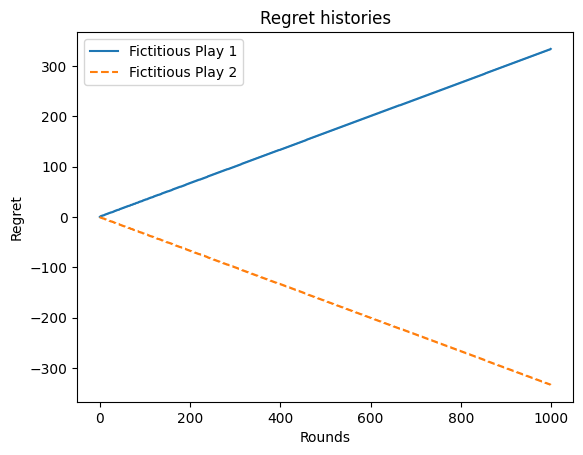

In [173]:
fp_self_play(1000)

### Interpretation

In the FP-self-play scenario, we can't see a Nash equilibrium (sigma: [1/3, 1/3, 1/3]). One agent exploits the historical moves of the other and both get stuck, with one winning the other, most of the time.

## FP vs Q-learning - Simple RPS

Here, we test the performance of an RL model - Q-learning - against a simpler one, FP.

In [174]:
def fp_vs_qlearning(rounds):

    regret_history_agent1 = []
    regret_history_agent2 = []
    cum_reward1 = 0
    cum_reward2 = 0
    
    env = RPS_environment(
        payoff_matrix=[
                 # R  P  S
                 [0, -1, 1],  # R
                 [1, 0, -1],  # P
                 [-1, 1, 0],  # S
        ]
    )

    # Row agent
    agent1 = FictitiousPlayAgent(
            [
                 #R  P  S
                [0, -1, 1],  # R
                [1, 0, -1],  # P
                [-1, 1, 0],  # S
            ]
        )

    agent2 = QLearning(epsilon_init=0.4)

    # Initializer
    last_act2 = None

    env.reset()

    for i in range(rounds):
        curr_env_state = env.state

        # Register actions
        curr_act1 = agent1.action(last_act2)
        curr_act2 = agent2.action(curr_env_state) # pass curr env state

        # Step the environment
        next_env_state, reward1, reward2 = env.step(curr_act1, curr_act2)

        cum_reward1 += reward1
        cum_reward2 += reward2
        regret_history_agent1.append(-cum_reward1)
        regret_history_agent2.append(-cum_reward2)

        # RL agent learns
        agent2.update_q_value(curr_env_state, curr_act2, reward2, next_env_state)

        last_act2 = curr_act2

    print(f"FP\ncounts: {agent1.counts}\nsigma: {agent1.sigma}\nScore: {env.score1}\nTotal reward: {env.reward1}")
    print("------------")
    print(f"Q-learning\nq_table: {agent2.q_table}\nScore: {env.score2}\nTotal reward: {env.reward2}")
    print(f"Draws: {env.draws}")
    plot_regret(rounds, regret_history_agent1, "Fictitious Play", regret_history_agent2, "QLearning")

FP
counts: [332, 338, 332]
sigma: [0.331, 0.337, 0.331]
Score: 288
Total reward: -85
------------
Q-learning
q_table: {0: [1.6856773043578959, 1.762832228260783, 1.3687925306767006]}
Score: 373
Total reward: 85
Draws: 339


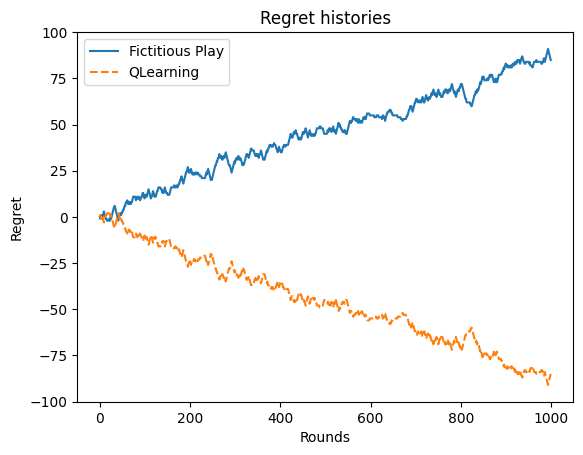

In [177]:
fp_vs_qlearning(1000)

### Interpretation

It's clearly visible that FP converges to a Nash equilibrium with a final `sigma` [1/3, 1/3, 1/3], while `Q-learning` has developed a strategy to exploit this with a `Q-table` [1.6856773043578959, 1.762832228260783, 1.3687925306767006]. These values show how the later, has created a strategy which exploits this historical tracking of FP and wins most of the time.

Additionally, we can see how in the beginning of the simulation, Q-learning tends to lose with its regret being slightly positive. However, after a few initial rounds, it converges to an optimal strategy against FP.

With an epsilon value pinned to `epsilon_init=0.4` for Q-Learning, the random moves turning to be hard to form a strategy against it.

## FP vs Q-learning decaying epsilon

In [192]:
def fp_vs_qlearning_decaying_epsilon(rounds):

    regret_history_agent1 = []
    regret_history_agent2 = []
    cum_reward1 = 0
    cum_reward2 = 0
    
    env = RPS_environment(
        payoff_matrix=[
                 # R  P  S
                 [0, -1, 1],  # R
                 [1, 0, -1],  # P
                 [-1, 1, 0],  # S
        ]
    )

    # Row agent
    agent1 = FictitiousPlayAgent(
            [
                 #R  P  S
                [0, -1, 1],  # R
                [1, 0, -1],  # P
                [-1, 1, 0],  # S
            ]
        )

    agent2 = QLearning_decaying_epsilon(epsilon_init=0.9, epsilon_decay=0.99, epsilon_decay_strategy="exp", epsilon_threshold=0.1)

    # Initializer
    last_act2 = None

    env.reset()

    for i in range(rounds):
        curr_env_state = env.state

        # Register actions
        curr_act1 = agent1.action(last_act2)
        curr_act2 = agent2.action(curr_env_state) # pass curr env state

        # Step the environment
        next_env_state, reward1, reward2 = env.step(curr_act1, curr_act2)

        cum_reward1 += reward1
        cum_reward2 += reward2
        regret_history_agent1.append(-cum_reward1)
        regret_history_agent2.append(-cum_reward2)

        # RL agent learns
        agent2.update_q_value(curr_env_state, curr_act2, reward2, next_env_state)

        last_act2 = curr_act2

    print(f"FP\ncounts: {agent1.counts}\nsigma: {agent1.sigma}\nScore: {env.score1}\nTotal reward: {env.reward1}")
    print("------------")
    print(f"Q-learning epsilon decay\nq_table: {agent2.q_table}\nScore: {env.score2}\nTotal reward: {env.reward2}")
    print(f"Draws: {env.draws}")
    plot_epsilon_regret(rounds, regret_history_agent1, "Fictitious Play", regret_history_agent2, "QLearning epsilon decay", epsilon_history2=agent2.epsilon_history)

FP
counts: [338, 323, 341]
sigma: [0.337, 0.322, 0.34]
Score: 328
Total reward: -22
------------
Q-learning epsilon decay
q_table: {0: [0.18466074250351397, 0.08093446479660549, -0.021374301378230376]}
Score: 350
Total reward: 22
Draws: 322


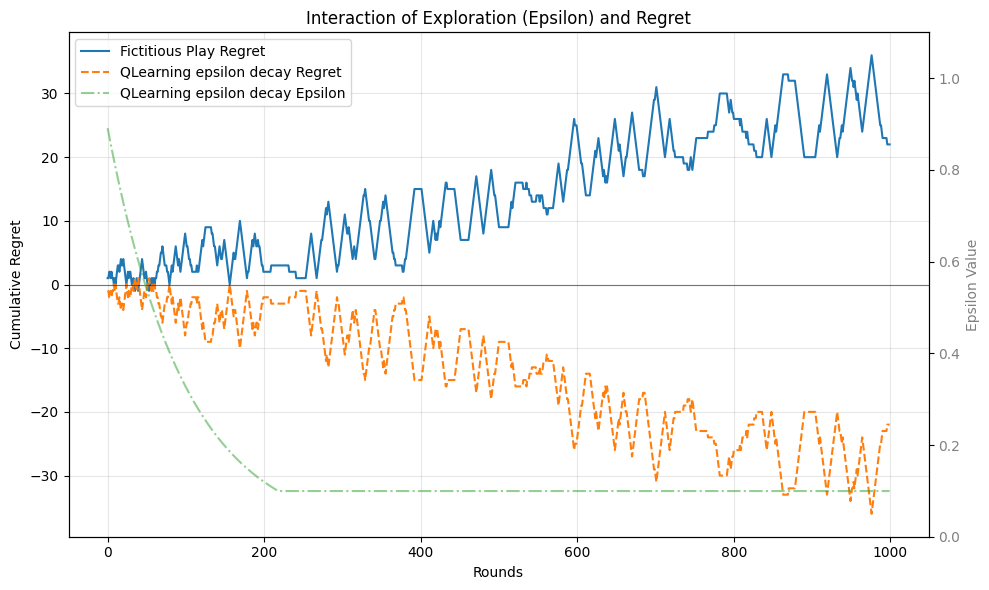

In [259]:
fp_vs_qlearning_decaying_epsilon(1000)

### Interpretation

In this scenario, we observe that while both agents successfully converge to the **Nash Equilibrium distribution** ($\sigma \approx 0.33, \pi \approx 0.33$), the cumulative regret continues to show a slight divergence. 

This can be interpreted in two ways:
1. **Historical Artifacts**: Cumulative regret captures the entire history of play. The current divergence reflects the "Learning Race" that occurred during the exploration phase (high epsilon), where the Q-learning agent successfully exploited the FP agent's initial stationary beliefs.
2. **Dynamic Cycling**: Fictitious Play is reactive to historical averages. If the Q-learner adapts its policy faster than the FP agent's counts can shift, the Q-learner can maintain a slight "Lead-Follow" advantage. 

However, the fact that the total reward (-22) is within the statistical margin of error for 1,000 rounds ($\pm 1\sigma$) suggests that the system has functionally reached a **Stochastic Nash Equilibrium**.

In [261]:
import numpy as np

rounds = 1000
# The variance of a single round (assuming 1/3, 1/3, 1/3) is 2/3.
std_dev = np.sqrt(rounds * (2/3))

print(f"Standard Deviation for {rounds} rounds: {std_dev:.2f}")
print(f"Observed Reward: -22")
print(f"Is -22 within 1 Standard Deviation? {abs(-22) < std_dev}")

Standard Deviation for 1000 rounds: 25.82
Observed Reward: -22
Is -22 within 1 Standard Deviation? True


## FP vs Nash Q-learning decaying epsilon

In [252]:
def fp_vs_nashqlearning_decaying_epsilon(rounds):

    regret_history_agent1 = []
    regret_history_agent2 = []
    cum_reward1 = 0
    cum_reward2 = 0
    
    env = RPS_environment(
        payoff_matrix=[
                 # R  P  S
                 [0, -1, 1],  # R
                 [1, 0, -1],  # P
                 [-1, 1, 0],  # S
        ]
    )

    # Row agent
    agent1 = FictitiousPlayAgent(
            [
                 #R  P  S
                [0, -1, 1],  # R
                [1, 0, -1],  # P
                [-1, 1, 0],  # S
            ]
        )

    # Agent 2: Minimax-Q (Nash) - Row Player
    agent2 = Minimax_QLearning(epsilon_init=0.9, epsilon_decay=0.99, epsilon_decay_strategy="exp", epsilon_threshold=0.1)

    # Initializer
    last_act2 = None

    env.reset()

    for i in range(rounds):
        curr_env_state = env.state

        # Register actions
        curr_act1 = agent1.action(last_act2)
        curr_act2 = agent2.action(curr_env_state) # pass curr env state

        # Step the environment
        next_env_state, reward1, reward2 = env.step(curr_act1, curr_act2)

        cum_reward1 += reward1
        cum_reward2 += reward2
        regret_history_agent1.append(-cum_reward1)
        regret_history_agent2.append(-cum_reward2)

        # RL agent learns
        agent2.update_q_value(curr_env_state, curr_act2, curr_act1, reward2, next_env_state)

        last_act2 = curr_act2

    print(f"FP\ncounts: {agent1.counts}\nsigma: {agent1.sigma}\nScore: {env.score1}\nTotal reward: {env.reward1}")
    print("------------")
    print(f"Q-learning epsilon decay\nq_table: {agent2.q_table}\npi-table: {agent2.pi}\nScore: {env.score2}\nTotal reward: {env.reward2}")
    print(f"Draws: {env.draws}")
    plot_epsilon_regret(rounds, regret_history_agent1, "Fictitious Play", regret_history_agent2, "Minimax_QLearning", epsilon_history2=agent2.epsilon_history)

FP
counts: [342, 338, 322]
sigma: [0.341, 0.337, 0.321]
Score: 315
Total reward: -46
------------
Q-learning epsilon decay
q_table: {0: array([[ 0.06484487, -0.93141694,  1.07056973],
       [ 1.00270489,  0.06860711, -0.92886491],
       [-0.80435985,  1.06858427,  0.07104057]])}
pi-table: {0: array([0.33255881, 0.32730699, 0.34013421])}
Score: 361
Total reward: 46
Draws: 324


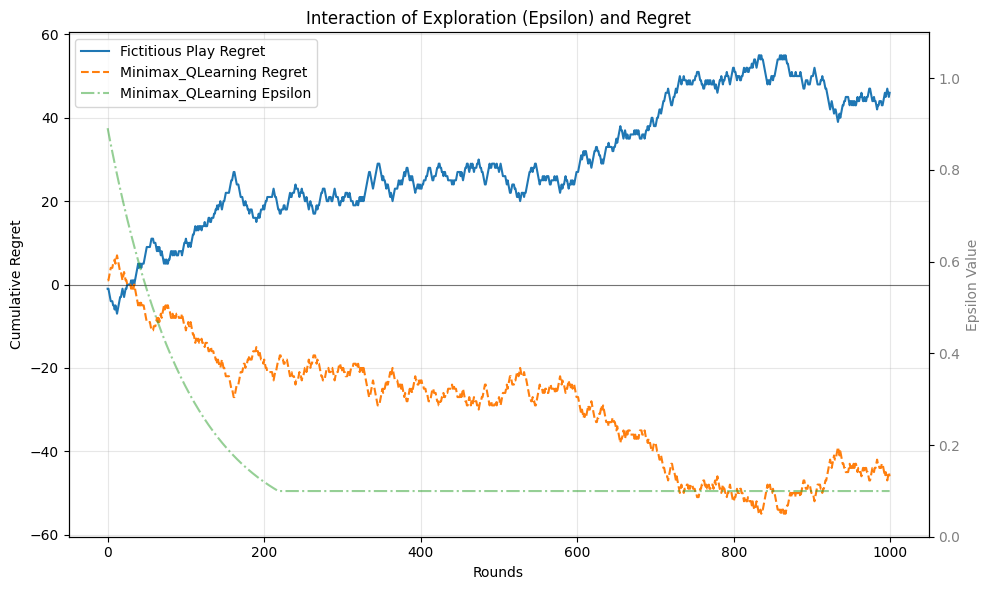

In [253]:
fp_vs_nashqlearning_decaying_epsilon(1000)

### Interpretation

Fictitious Play exhibits consistent convergence toward the `[1/3,1/3,1/3]`, Nash Equilibrium. Because it maintains a comprehensive history of opponent moves, its strategy becomes increasingly stable as the number of rounds increases.

The experimental data confirms successful convergence to a Mixed Strategy Nash Equilibrium. Both the model-based Fictitious Play agent (σ≈0.33) and the model-free Minimax Q-Learning agent (π≈0.33) reached the theoretical optimum.

The Q-table values align with the stage-game payoffs, adjusted for the discount factor γ. The final reward of +46 for the Nash-Q agent is a relic of the stochastic exploration phase, while the final policy distributions confirm that neither agent can be further exploited by the other.

## Q-learning decaying epsilon vs Nash Q-Learning

In [254]:
import numpy as np
from scipy.optimize import linprog

def qlearning_vs_minimax_q(rounds):

    # Init metrics
    regret_history_agent1 = []
    regret_history_agent2 = []
    cum_reward1 = 0
    cum_reward2 = 0
    
    # Setup environment
    env = RPS_environment(
        payoff_matrix=[
            [0, -1, 1],  # R
            [1, 0, -1],  # P
            [-1, 1, 0],  # S
        ]
    )

    # Agent 1: Minimax-Q (Nash) - Row Player
    agent1 = Minimax_QLearning(epsilon_init=0.9, epsilon_decay=0.01, epsilon_decay_strategy="lin", epsilon_threshold=0.1)

    # Agent 2: Standard Q-Learning - Column Player
    agent2 = QLearning_decaying_epsilon(epsilon_init=0.9, epsilon_decay=0.994, epsilon_decay_strategy="exp", epsilon_threshold=0.1)

    env.reset()

    for i in range(rounds):
        curr_state = env.state

        # 1. Get Actions
        act1 = agent1.action(curr_state)
        act2 = agent2.action(curr_state)

        # 2. Step Environment
        next_state, r1, r2 = env.step(act1, act2)

        # 2.5 Update metrics
        cum_reward1 += r1
        cum_reward2 += r2
        regret_history_agent1.append(-cum_reward1)
        regret_history_agent2.append(-cum_reward2)

        # 3. Update Minimax-Q (Requires BOTH actions)
        agent1.update_q_value(curr_state, act1, act2, r1, next_state)

        # 4. Update Standard Q-Learning (Only requires its own action)
        agent2.update_q_value(curr_state, act2, r2, next_state)

    # Final Reporting
    print(f"Minimax-Q (Nash)\nScore: {env.score1}\nTotal reward: {env.reward1}")
    print(f"V(s=0): {agent1.V[0]:.4f}")
    print(f"Policy(s=0): {np.round(agent1.pi[0], 3)}")
    print("------------")
    print(f"Standard Q-learning\nScore: {env.score2}\nTotal reward: {env.reward2}")
    print(f"Q-table(s=0): {np.round(agent2.q_table[0], 3)}")
    print("------------")
    print(f"Draws: {env.draws}")
    # plot_regret(rounds, regret_history_agent1, "Minimax-Q", regret_history_agent2, "Standard Q-learning")
    plot_epsilon_regret(rounds, regret_history_agent1, "Minimax-Q", regret_history_agent2, "Standard Q-learning", epsilon_history1=agent1.epsilon_history ,epsilon_history2=agent2.epsilon_history)

Minimax-Q (Nash)
Score: 335
Total reward: 18
V(s=0): 0.0023
Policy(s=0): [0.333 0.333 0.334]
------------
Standard Q-learning
Score: 317
Total reward: -18
Q-table(s=0): [-0.396 -0.051 -0.255]
------------
Draws: 348


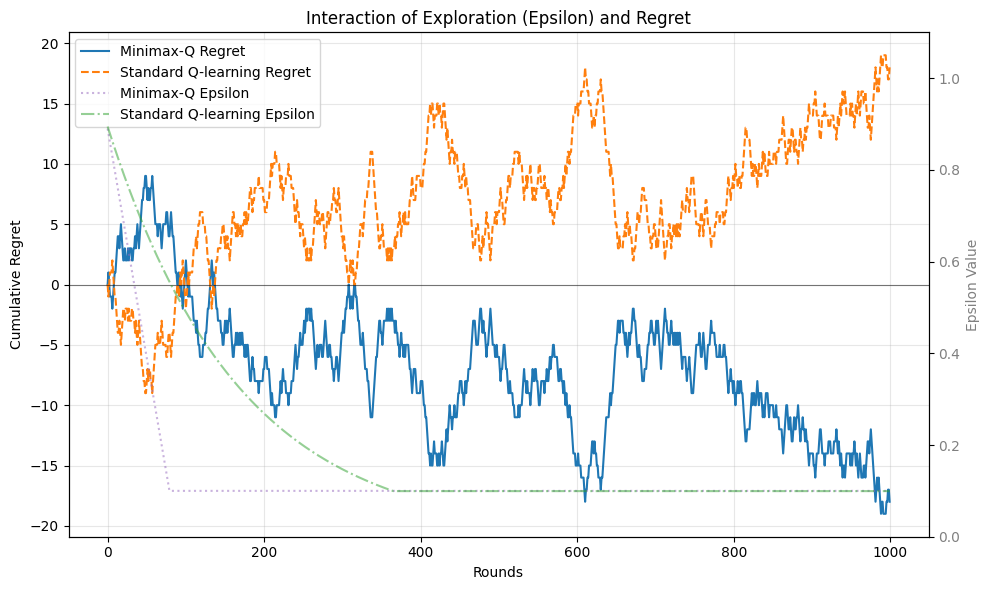

In [256]:
qlearning_vs_minimax_q(1000)

### Interpretation

The experimental results demonstrate a clear distinction between a theoretically robust adversarial agent and a naive reinforcement learner in a zero-sum environment.

**Strategic Dominance and Nash Convergence**

The Minimax-Q (Nash) agent reached an empirical policy of `[0.333, 0.333, 0.334]`, aligning perfectly with the theoretical Nash Equilibrium for Rock-Paper-Scissors. This stability is further validated by a calculated state value V(s=0)=0.0023, which confirms the algorithm successfully identified the security level of the game as zero. By solving the underlying linear program, the agent transitioned from exploration to an unexploitablity-focused strategy.

**Standard Q-Learning Policy Collapse**

In contrast, the Standard Q-learning agent exhibited "policy collapse." Its Q-table values for the initial state settled into a purely negative range (e.g., [-0.396, -0.051, -0.255]) - as mentioned in the theory above. This behavior illustrates the "Exploitation Trap": the agent failed to model the opponent’s actions and instead perceived its environment as consistently punishing. By essentially chasing the least negative value, the standard learner became predictable, allowing the adversarial agent to maintain a positive reward margin.

**Regret Divergence and Equilibrium Dynamics**

The diverging cumulative regret lines do not indicate a failure to learn, but rather the presence of strategic dominance. Because the Minimax-Q agent secured the Nash Equilibrium, it became mathematically unexploitable, somewhere in round 100. The Standard Q-learner, lacking this adversarial defense, continued to exhibit biases that were systematically capitalized upon by the stabilized Nash policy.

# References

Nash Q-learning
- https://dl.acm.org/doi/pdf/10.5555/945365.964288

What's FP:
- https://en.wikipedia.org/wiki/Fictitious_play

FP Agent design:
- https://www.youtube.com/watch?v=_XIdEr-wtJg

FP Agent beliefs initialization:
- https://cse.unl.edu/~lksoh/Classes/CSCE475_875_Fall17/handouts/sup09.pdf

Lectures
- https://lefkippos.ds.unipi.gr/modules/document/file.php/AI_IIT113/Lectures%205%20%26%206%20Agents-Interactions_Game_Theory.pdf

# DONE

- [x] imlement beefy RPS env
- [x] implement FP agent
- [x] implement q-learning agent
- [x] Move into notebook
- [x] implement **decaying** epsilon
- [x] break into modules
- [x] **implement minmax q-learning** - https://github.com/tocom242242/minimax_q_learning - https://dl.acm.org/doi/pdf/10.5555/945365.964288

# TODO

- [ ] Convert into stochastic with limit cap
- [ ] extract metrics [scores, env.state, q-table, sigma, epsilon, diagrams, experiments, interpretations, self-plays]
- [ ] use petting zoo for RPS
- [ ] research - competitive grid world
- [ ] research - implement pong game (discrete actions)
- [ ] research - hunter-pray game gridworld
- [ ] research - implement multi-agent shooting game
- [ ] implement SARSA agent - https://www.geeksforgeeks.org/machine-learning/sarsa-reinforcement-learning/
- [ ] practical application ???
- [ ] evolutionary algorithms - research
- [ ] bomb difusal game/environment
- [ ] penalties game/environment


# Resources

READ THIS FIRST: https://lefkippos.ds.unipi.gr/modules/document/file.php/AI_IIT113/Lectures%205%20%26%206%20Agents-Interactions_Game_Theory.pdf

- Q-Learning (Pong) - https://courses.grainger.illinois.edu/ece448/sp2018/assignment4.html
- evolutionary algo - https://www.cs.vu.nl/~gusz/ecbook/Eiben-Smith-Intro2EC-Ch2.pdf
- evolutionary rl - https://github.com/RichardAragon/EvolutionaryReinforcementLearning
- paper to get games, metrics, algos - https://github.com/shiivashaakeri/Pong-Deep-QLearning/blob/main/Report.pdf
- q-learning tutorial - https://www.geeksforgeeks.org/machine-learning/q-learning-in-python/
- book implementations for RL - https://github.com/ShangtongZhang/reinforcement-learning-an-introduction
- RL taxonomy - https://github.com/bennylp/RL-Taxonomy
- OpenAI RL taxonomy - https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html
- SARSA - https://github.com/linesd/tabular-methods/blob/master/algorithms/temporal_difference.py; https://www.geeksforgeeks.org/machine-learning/sarsa-reinforcement-learning/
- ALL RL ALGOS - https://github.com/FareedKhan-dev/all-rl-algorithms/blob/master/cheatsheet.md
- RL algorithms paper - https://arxiv.org/pdf/2209.14940
- minmax q-learning - https://github.com/tocom242242/minimax_q_learning/blob/master/minimax_q_learner.py; https://github.com/theevann/MinimaxQ-Learning
- Multi-Step Minimax Q-learning Algorithm for Two-Player Zero-Sum Markov Games - https://arxiv.org/abs/2407.04240
- Policies in MDPS and games - https://courses.cs.duke.edu/spring07/cps296.3/littman94markov.pdf

---